# Two dimensional Cartesian Slepians, generalized

The idea here is to use slepian_foxtrot to jumpstart an implementation of the Simons code. We should be able to then localize blobs, or splined boundaries of things in order to get the GL nodes and solve the concentration problem. 

`slepian_foxtrot` depends on `slepian_alpha`, so the routines from `slepian_alpha` that are needed have been collected in an input file. 

In [1]:
using FastGaussQuadrature, Plots, DelimitedFiles, Random, Slepians, KernelMatrices, Interpolations
using KrylovKit, IterTools, FFTW #, LaTeXStrings
Random.seed!(123)
using Revise
include("../src/relevant_slepian_alpha.jl")
#import Slepians: get_quadrature_nodes_2D

#include("relevant_slepian_alpha.jl")

include("RHMatrix.jl")

Main.RHMatrix

## Random blob example

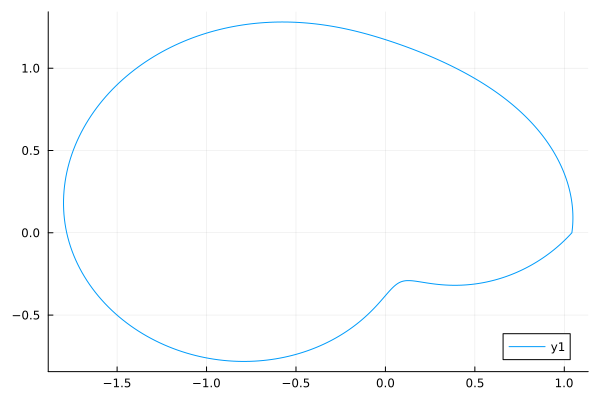

In [2]:
x,y = Slepians.randcirc(0.0,0.0,1.0,1,4)

plot(x,y)

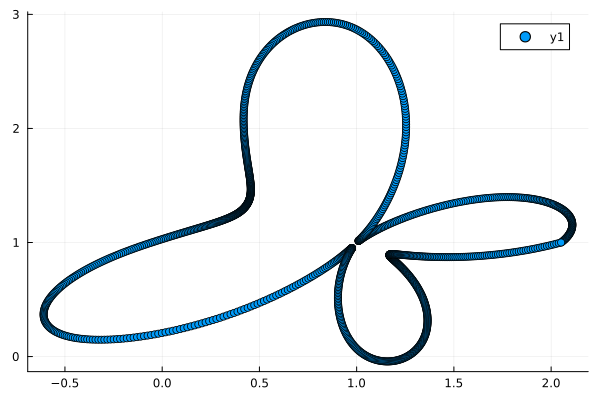

In [3]:
x,y = Slepians.randcirc(1.0,1.0,1.0,1,12)

scatter(x,y)

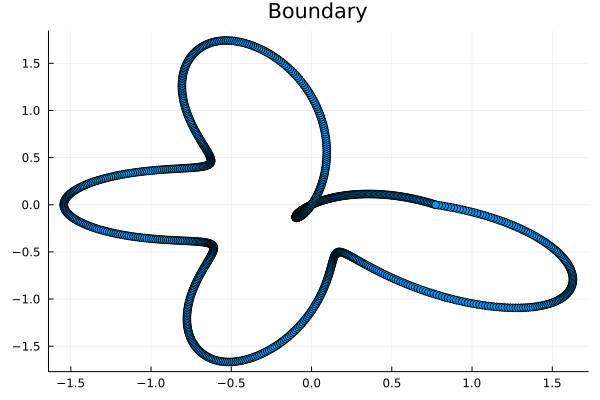

In [8]:
x, y = Slepians.blob(1,1)

p = scatter(x[1], y[1],  marker = :o, title = "Boundary", legend = false)

## Get the quadrature nodes

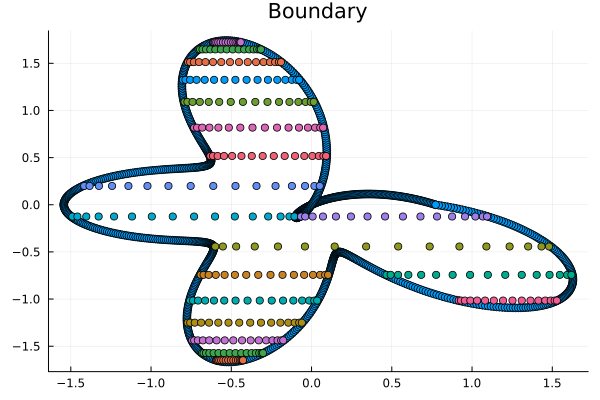

In [9]:
QX, QY, w, Nrun = get_quadrature_nodes_2D(x[1], y[1], 16, 16)

# Initialize the quadrature points
scatter!(p, QX, QY, legend = false)

## Integrate

Now we just use the code that does the numerical integration, and Bob's your uncle.

In [10]:
include("ext.jl")

customsleps_ext (generic function with 1 method)

In [11]:
# Set the parameters for the custom Slepians

M  = 3
Kp = [4.0]
szs = int = (16, 16)
prec = 1e-8
exact = false
lvl = 6
maxrank = 256


256

In [12]:
no    = map(i->(QX[i], QY[i]), 1:prod(size(QX)))
sqwt = sqrt.(w[:]);

Get the nodes and weights into the sizes and shapes that the solving routine wants.

In [13]:
ev = vec(collect(product([range(minimum(QX), maximum(QX), length = szs[1]), range(minimum(QY), maximum(QY), length = szs[2]) ]...)))
s, sl = customsleps_ext(M, Kp, szs, prec = prec, exact = exact, lvl = lvl, maxrank = maxrank, no = no,
        sqwt = sqwt, int = nothing, ev = ev);
s

19-element Vector{ComplexF64}:
    0.5010072593724911 + 0.0im
   0.45450916859198087 + 0.0im
   0.43600725389738854 + 0.0im
   0.39718268849551835 + 0.0im
     0.324775814319835 + 0.0im
    0.2518576130398666 + 0.0im
   0.19932241981549526 + 0.0im
    0.1349966749296104 + 0.0im
   0.10177760030143981 + 0.0im
   0.08669151945105716 + 0.0im
   0.06464619036147765 + 0.0im
   0.04943668230971173 + 0.0im
  0.029050254170862214 + 0.0im
   0.02185350221431143 + 0.0im
  0.016442900372178427 + 0.0im
  0.010251543085688734 + 0.0im
  0.009006366057870537 + 0.0im
 0.0043803731871299885 + 0.0im
  0.003827897460863545 + 0.0im

Plot the results

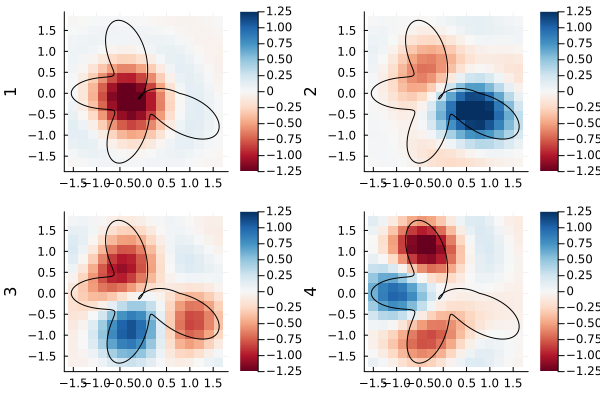

In [14]:
p1 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
p2 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
ran = 1:4
for i = ran
    p1[i] = heatmap(range(minimum(QX), maximum(QX), length = szs[1]), 
         range(minimum(QY), maximum(QY), length = szs[2]), Float64.(sl[i])',
        c = :RdBu, clims = (-1.25, 1.25), ylabel = i)
    # this transpose is important
    plot!(p1[i], x[1], y[1], legend = false, c = :black)

    SL = abs2.(fftshift(fft(sl[i])))
    p2[i] = heatmap(range(-1.0, 1.0, length=szs[2]+1)[1:szs[2]],range(-1.0, 1.0, length=szs[1]+1)[1:szs[1]],
        log10.(SL), ylabel = i)
end

plot(p1[ran]...)

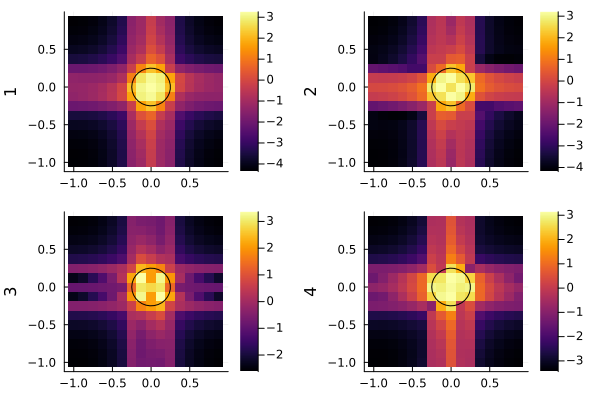

In [15]:
qq = plot(p2[ran]..., legend = false)

for i = 1:4
    plot!(qq[i], (Kp[1]/szs[1])*cos.(range(-pi, pi, length=30)), 
        (Kp[1]/szs[2])*sin.(range(-pi, pi, length=30)), c = :black)
end

qq

## Second example - rattle shape

How does the code set up quadrature nodes for disjoint circles?

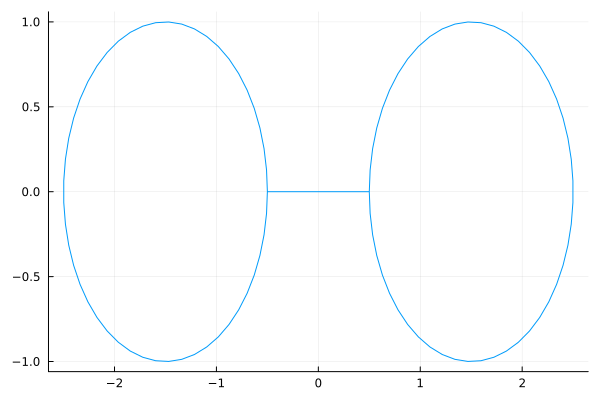

In [16]:
N = 50
t = LinRange(-pi, pi, N)
x1, y1 = (cos.(t) .+ 1.5, sin.(t))
x2, y2 = (cos.(t .+ pi) .- 1.5, sin.(t .+ pi))
xp,yp = (vcat(x1, x2), vcat(y1, y2))

plot(xp,yp, legend = false)

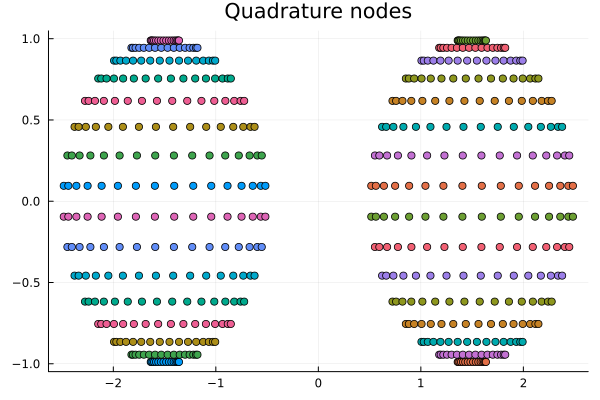

In [17]:
QXp, QYp, wp, Nrunp = get_quadrature_nodes_2D(xp, yp, 16, 16)
psp = scatter(QXp, QYp, legend = false, title = "Quadrature nodes")

In [18]:
nop    = map(i->(QXp[i], QYp[i]), 1:prod(size(QXp)))
sqwtp = sqrt.(wp[:]);
size(sqwtp)

(512,)

In [19]:
evp = vec(collect(product([range(minimum(QXp), maximum(QXp), length = szs[1]), range(minimum(QYp), maximum(QYp), length = szs[2]) ]...)))
M = 1
sp, slp = customsleps_ext(M, Kp, szs, prec = prec, exact = exact, lvl = lvl, maxrank = maxrank, no = nop,
        sqwt = sqwtp, int = nothing, ev = evp);

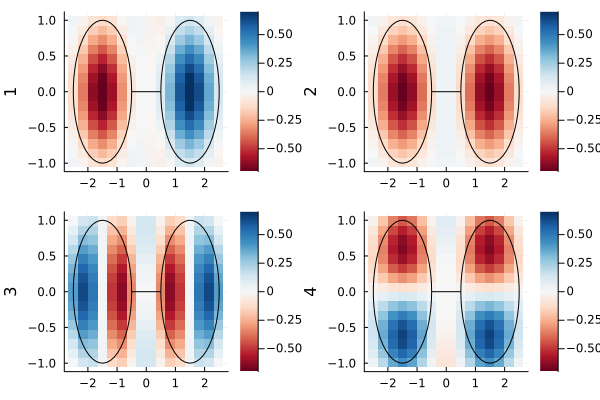

In [20]:
p1 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
p2 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
ran = 1:4
for i = ran
    p1[i] = heatmap(range(minimum(QXp), maximum(QXp), length = szs[1]), 
         range(minimum(QYp), maximum(QYp), length = szs[2]), Float64.(slp[i])',
        c = :RdBu, ylabel = i, clims = (-0.7, 0.7)) # this transpose is important
    plot!(p1[i], xp, yp, legend = false, c = :black)

    SL = abs2.(fftshift(fft(slp[i])))
    p2[i] = heatmap(range(-1.0, 1.0, length=szs[2]+1)[1:szs[2]],0.5*range(-1.0, 1.0, length=szs[1]+1)[1:szs[1]],
        log10.(SL), ylabel = i)
end

plot(p1[ran]...)
#png("rattle")

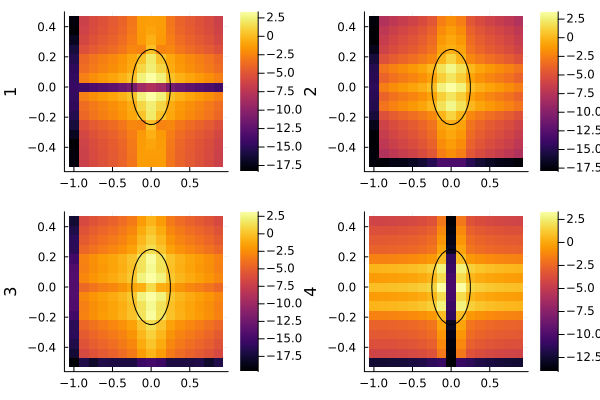

In [21]:
qq = plot(p2[ran]..., legend = false)

for i = 1:4
    plot!(qq[i], (Kp[1]/szs[1])*cos.(range(-pi, pi, length=30)), 
        (Kp[1]/szs[2])*sin.(range(-pi, pi, length=30)), c = :black)
end

qq
#png("locrattle")

In [22]:
plot(p2[2])
plot!(p2[2], (Kp[1]/szs[1])*cos.(range(-pi, pi, length=30)), 
        (Kp[1]/szs[2])*sin.(range(-pi, pi, length=30)), c = :black)

plot(p1[2], p2[2], title = ["Q-space" "Correlation Space"], size = (900, 350), 
    colorbar_title = ["Magnitude" "log abs value"], 
    xlabel = ["Qh" "x"], ylabel = ["Qk" "y"],
    layout = (1,2), legend = false)
png("rattle")

"rattle.png"

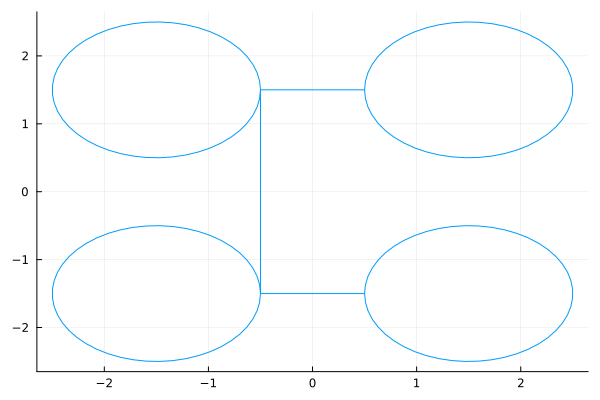

In [23]:
N = 50
t = LinRange(-pi, pi, N)
x1, y1 = (cos.(t) .+ 1.5, sin.(t) .+ 1.5)
x2, y2 = (cos.(t .+ pi) .- 1.5, sin.(t .+ pi) .+ 1.5)
x3, y3 = (cos.(t .+ pi) .- 1.5, sin.(t .+ pi) .- 1.5)
x4, y4 = (cos.(t) .+ 1.5, sin.(t) .- 1.5)

xp,yp = (vcat(x1, x2, x3, x4, x3[1], x2[1], x1[1]), vcat(y1, y2, y3, y4, y3[1], y2[1], y1[1]))

plot(xp,yp, legend = false)

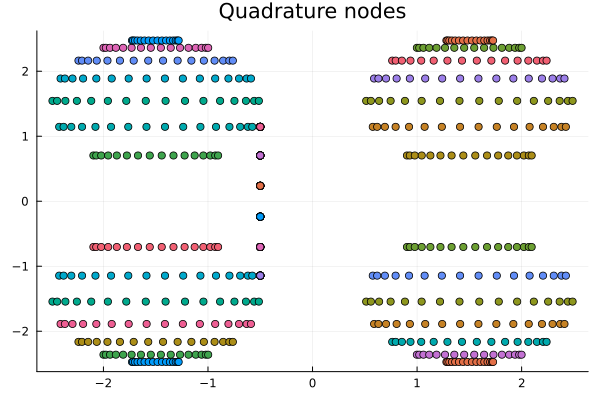

In [24]:
QXp, QYp, wp, Nrunp = get_quadrature_nodes_2D(xp, yp, 16, 16)
psp = scatter(QXp, QYp, legend = false, title = "Quadrature nodes")

In [25]:
nop    = map(i->(QXp[i], QYp[i]), 1:prod(size(QXp)))
sqwtp = sqrt.(wp[:]);
size(sqwtp)

evp = vec(collect(product([range(minimum(QXp), maximum(QXp), length = szs[1]), range(minimum(QYp), maximum(QYp), length = szs[2]) ]...)))

sp, slp = customsleps_ext(M, Kp, szs, prec = prec, exact = exact, lvl = lvl, maxrank = maxrank, no = nop,
        sqwt = sqwtp, int = nothing, ev = evp);

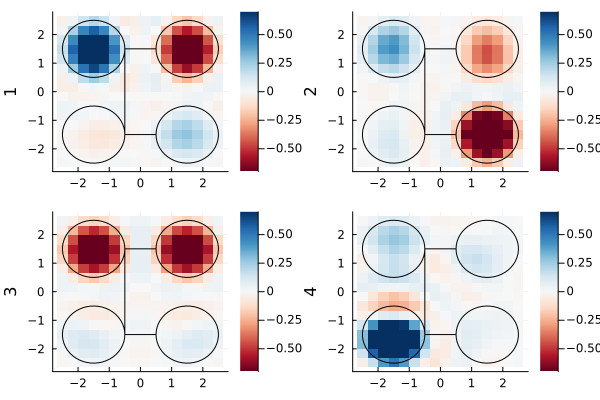

In [26]:
p1 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
p2 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
ran = 1:4
for i = ran
    p1[i] = heatmap(range(minimum(QXp), maximum(QXp), length = szs[1]), 
         range(minimum(QYp), maximum(QYp), length = szs[2]), Float64.(slp[i])',
        c = :RdBu, ylabel = i, clims = (-0.7, 0.7)) # this transpose is important
    plot!(p1[i], xp, yp, legend = false, c = :black)

    SL = abs2.(fftshift(fft(slp[i])))
    p2[i] = heatmap(0.5*range(-1.0, 1.0, length=szs[2]+1)[1:szs[2]],0.5*range(-1.0, 1.0, length=szs[1]+1)[1:szs[1]],
        log10.(SL), ylabel = i)
end

plot(p1[ran]...)
#png("circles")

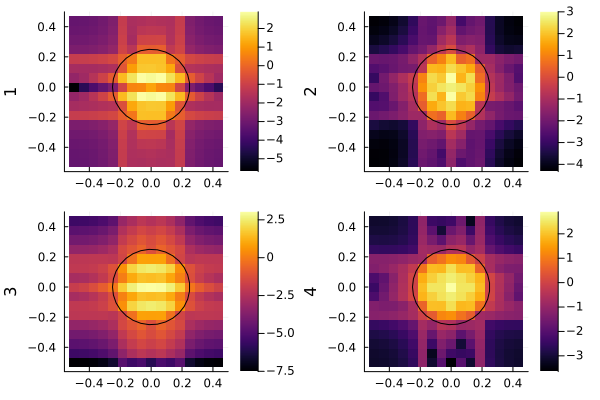

In [27]:
qq = plot(p2[ran]..., legend = false)

for i = 1:4
    plot!(qq[i], (Kp[1]/szs[1])*cos.(range(-pi, pi, length=30)), 
        (Kp[1]/szs[2])*sin.(range(-pi, pi, length=30)), c = :black)
end

qq
#png("circles_loc")